In [230]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# jax
import jax.numpy as jnp
import time

import sys
import os
import importlib

# append path
path_ = os.path.abspath(os.path.join('..', '00_utils'))
if path_ not in sys.path:
    sys.path.append(path_)
    
path_ = os.path.abspath(os.path.join('..', '00_models'))
if path_ not in sys.path:
    sys.path.append(path_)
    
path_ = os.path.abspath(os.path.join('..', '00_utils_training'))
if path_ not in sys.path:
    sys.path.append(path_)

from data_generation import generate_ode_data
from non_parametric_collocation import collocate_data
from collocation_obj import Collocation

def reload_module(module_name, class_name):
    module = importlib.import_module(module_name)
    importlib.reload(module)
    return getattr(module, class_name)

In [231]:
PyomoModel = reload_module('nn_pyomo_base', 'NeuralODEPyomo')

class DataPreprocessor:
    def __init__(self, data_param):
        self.model_type = 'pyomo'
        self.N = data_param['N']
        self.noise_level = data_param['noise_level']
        self.ode_type = data_param['ode_type']
        self.data_param = data_param['extra_param']
        self.spacing_type = data_param['spacing_type']
        self.start_time = data_param['start_time']
        self.end_time = data_param['end_time']
        self.init_state = data_param['initial_state']
        self.test_size = getattr(data_param, 'test_size', None)
        
    def load_data(self):
        if self.model_type == 'pyomo':
            self.generate_nodes()
        else:
            self.nodes = jnp.linspace(self.start_time, self.end_time, self.N)
        
        # training    
        self.t, self.y, self.y_noisy, true_derivative = generate_ode_data(
            self.N, self.noise_level, self.ode_type, self.data_param, 
            min(self.nodes), max(self.nodes), 
            initial_state = self.init_state, t = self.nodes)
        
        self.true_derivative = true_derivative
        
        if self.test_size is not None:
            test_end_time = self.end_time + self.test_size
        else:
            test_end_time = max(self.nodes) + (max(self.nodes) - min(self.nodes))
        
        # testing
        self.init_state_test = self.y[-1]
        t_test, y_test, _, _ = generate_ode_data(
            self.N*2, self.noise_level, self.ode_type, self.data_param, 
            max(self.nodes), test_end_time, 
            spacing_type = "uniform", 
            initial_state = self.init_state_test)
        
        self.t_test = t_test
        self.y_test = y_test

    def generate_nodes(self):
        collocation = Collocation(self.N, self.start_time, self.end_time, self.spacing_type)
        self.nodes = collocation.compute_nodes()
        self.collocation = collocation
       
    def prepare_collocation(self):
        self.D = np.array(self.collocation.compute_derivative_matrix())
        
    def estimate_derivative(self):
        est_der, est_sol = collocate_data(self.y_noisy, self.t, 'EpanechnikovKernel', bandwidth=0.5)
        self.est_sol = np.array(est_sol)

In [232]:
def generate_admm_data(initial_state):
    data_params_vdp = {
        'N': 150, 'noise_level': 0.1,
        'ode_type': "van_der_pol",
        'extra_param': {"mu": 1, "omega": 1},
        'spacing_type': 'gauss_radau',
        'initial_state': initial_state,
        'detailed' : False
    }

    time_intervals = [(0, 15), (15, 30)]

    t_list, y_true_list, y_noisy_list = [], [], []
    D_list = []
    est_sol_list = []

    # --------------------------------------------- GENERATE DATA FOR EACH INTERVAL --------------------------------------------- #
    for idx, (start_time, end_time) in enumerate(time_intervals):
        # update initial state for subsequent intervals
        if idx > 0:
            data_params_vdp['initial_state'] = y_true_list[-1][-1] 
        
        data_params_vdp['start_time'] = start_time
        data_params_vdp['end_time'] = end_time
        
        data_prep = DataPreprocessor(data_params_vdp)
        data_prep.load_data()
        data_prep.prepare_collocation()
        data_prep.estimate_derivative()
        
        # training
        y_noisy_list.append(data_prep.y_noisy)
        t_list.append(data_prep.t)
        D_list.append(data_prep.D)
        y_true_list.append(data_prep.y)
        est_sol_list.append(data_prep.est_sol)
        
    # --------------------------------------------- MERGE DATA FROM ALL INTERVALS --------------------------------------------- #
    ts = np.concatenate(t_list)      
    ys = np.vstack(y_noisy_list)     
    y_est = np.hstack(est_sol_list)  
    Ds = D_list          

    ys = np.array(ys)
    ts = np.array(ts)
    y_est = np.array(y_est).T
    
    return ts, ys, y_est, Ds

In [233]:
#initial_states = [np.random.rand(2) for _ in range(10)]

initial_states = [np.array([0.0, 1.0])]
ts, ys, y_est, Ds = generate_admm_data(initial_states[0])

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_utils/non_parametric_collocation.py:95: UserWarning: Data transposed to match expected dimensions.
  warnings.warn("Data transposed to match expected dimensions.")
/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_utils/non_parametric_collocation.py:95: UserWarning: Data transposed to match expected dimensions.
  warnings.warn("Data transposed to match expected dimensions.")


In [234]:
ode_model.model1.dual_W1

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [235]:
import nn_pyomo_admm
importlib.reload(nn_pyomo_admm)
NeuralODEPyomoADMM = nn_pyomo_admm.NeuralODEPyomoADMM

initial_states = [np.array([0.0, 1.0])]
results = []

for i, state in enumerate(initial_states):
        ts, ys, y_est, Ds = generate_admm_data(state)
        tol = 1e-8
        params = {"tol":tol, 
                #"dual_inf_tol": tol, "compl_inf_tol": tol, "constr_viol_tol": tol, 
                "halt_on_ampl_error" : 'yes', 
                "print_level": 5, "max_iter": 3000}

        layer_sizes = [2, 32, 2]

        ode_model = NeuralODEPyomoADMM(y_observed = ys, 
                                t = ts, # t
                                first_derivative_matrix = Ds, # derivative matrix
                                extra_input = None, # extra inputs
                                y_init = y_est,
                                layer_sizes = layer_sizes, act_func = "tanh", 
                                penalty_lambda_reg = 0.001, 
                                rho = 1.0,
                                time_invariant = True,
                                w_init_method = 'xavier', 
                                params = params
                                )

        results.append(ode_model.admm_solve(iterations=10, tol_primal=1e-2, record = True))

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_utils/non_parametric_collocation.py:95: UserWarning: Data transposed to match expected dimensions.
  warnings.warn("Data transposed to match expected dimensions.")
/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_utils/non_parametric_collocation.py:95: UserWarning: Data transposed to match expected dimensions.
  warnings.warn("Data transposed to match expected dimensions.")


----------------------------------------------------------------------------------------------------
ADMM Iteration 1/10; 0
----------------------------------------------------------------------------------------------------
Ipopt 3.14.16: tol=1e-08
halt_on_ampl_error=yes
print_level=5
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:    83440
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    48579

Total number of variables.....................

In [225]:
results

[{'primal_residual': [42.55356270393104,
   42.553562703931945,
   6.437837806483853,
   3.953021235603151,
   3.2963386061725517,
   3.027518928376167,
   1.8490583457562373,
   1.4506131594427005,
   1.2402473597429893,
   1.1063882692709488],
  'mse_diffrax': [865.9722061336192,
   865.9722061366543,
   18.93042517255787,
   2.9482185786870967,
   3.0676772768293152,
   3.564734526125619,
   2.3682628013198386,
   0.17033541360697024,
   0.13417887024186737,
   0.19703773090680882],
  'iter': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
  'time_elapsed': [11.574979782104492,
   12.114282608032227,
   15.424358606338501,
   16.127046585083008,
   16.716712713241577,
   17.364927530288696,
   18.325222492218018,
   19.2341365814209,
   19.82904553413391,
   20.43921947479248]}]

In [226]:
result['time_elapsed']

[9.408544778823853,
 9.916497945785522,
 12.97542691230774,
 13.526719808578491,
 14.153052568435669,
 14.692862510681152,
 15.465918779373169,
 16.031964778900146,
 16.581223011016846,
 17.119141340255737]

In [227]:
result['primal_residual']

[42.55356270393104,
 42.553562703931945,
 6.437837806483863,
 3.9530212356031695,
 3.2963386061725592,
 3.027518928376186,
 1.8490583457562597,
 1.4506131594427034,
 1.2402473597429917,
 1.1063882692709437]

In [228]:
admm_mse_diffrax = result['mse_diffrax']

In [216]:
case = 1
if case == 0:
    init_state = data_params_vdp['initial_state'] 
elif case == 1:
    init_state = jnp.array([0,1])
    
pred = ode_model.node_diffrax_pred(init_state, jnp.array(ts), None, 'consensus')

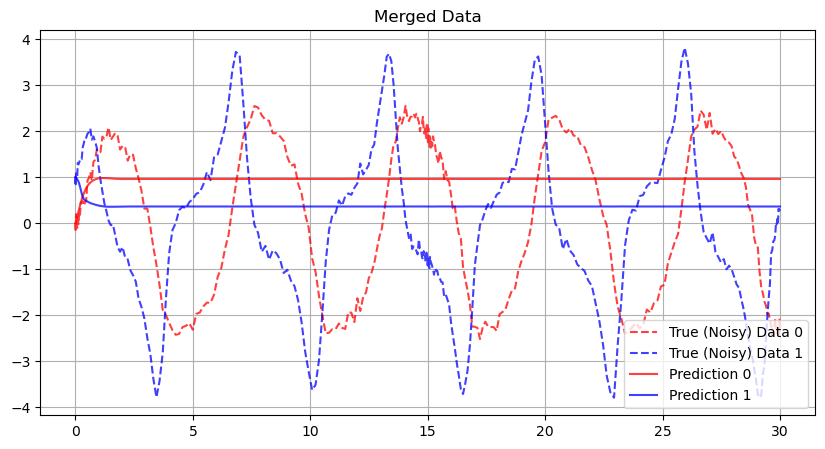

In [217]:
plt.figure(figsize=(10, 5))
plt.plot(ts, ys[:, 0], label='True (Noisy) Data 0', color = 'red', ls = '--', alpha = 0.75)
plt.plot(ts, ys[:, 1], label='True (Noisy) Data 1', color = 'blue', ls = '--', alpha = 0.75)

plt.plot(ts[:], pred[:,0], label='Prediction 0', color = 'red', alpha = 0.75)
plt.plot(ts[:], pred[:,1], label='Prediction 1', color = 'blue', alpha = 0.75)
plt.legend(loc ="lower right")
plt.grid(True)
plt.title("Merged Data")
plt.show()

---
---
### Single Model

In [179]:
data_params_vdp_full = {
    'N': 300, 'noise_level': 0.2, 'test_size': 200,
    'ode_type': "van_der_pol",
    'extra_param': {"mu": 1, "omega": 1},
    'start_time': 0, 'end_time': 30,
    'spacing_type': 'chebyshev', #'gauss_radau',
    'initial_state': np.array([0.0, 1.0]),
    'detailed' : False
}

data_prep = DataPreprocessor(data_params_vdp_full)
data_prep.load_data()
data_prep.prepare_collocation()
data_prep.estimate_derivative()

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_utils/non_parametric_collocation.py:95: UserWarning: Data transposed to match expected dimensions.
  warnings.warn("Data transposed to match expected dimensions.")


In [180]:
ys_single_true = np.array(data_prep.y)
ys_single = np.array(data_prep.y_noisy)
print(ys_single.shape)
ts_single = np.array(data_prep.t)
Ds_single = np.array(data_prep.D)
y_est_single = np.array(data_prep.est_sol)

(300, 2)


In [181]:
class TrainerToyLocal:
    def __init__(self, y_noisy, t, D, layer_widths, act_func = 'tanh', y_init = None, penalty_lambda_reg = 0.001, time_invar = True, w_init_method = 'xavier', reg_norm = False, skip_collocation = np.inf):       
            
            self.y_noisy = y_noisy
            self.t = t
            self.D = D
            self.layer_widths = layer_widths
            self.act_func = act_func
            self.est_sol = y_init
            self.lambda_reg = penalty_lambda_reg
            self.time_invar = time_invar
            self.w_init_method = w_init_method
            self.reg_norm = reg_norm
            self.skip_collocation = skip_collocation
            
            self.pre_initialize = True
            self.time_elapsed = None
            self.termination = None
        
    def train_pyomo(self, params_model = None):
        
        self.model = PyomoModel(
                        self.y_noisy, # remember to pass noisy data
                        self.t, 
                        self.D,
                        self.layer_widths, 
                        act_func = self.act_func, 
                        y_init = self.est_sol, 
                        penalty_lambda_reg = self.lambda_reg, 
                        time_invariant = self.time_invar,
                        w_init_method = self.w_init_method, 
                        params = params_model,
                        reg_norm = self.reg_norm,
                        skip_collocation = self.skip_collocation
                        )
        
        self.model.build_model()
        result = self.model.solve_model()        
        self.time_elapsed = result['solver_time']
        self.termination = result['termination_condition']
        self.result = result
        print(result)

tol = 1e-8
params = {"tol" : tol, 
          #"dual_inf_tol": tol, 
          #"compl_inf_tol": tol, 
          #"constr_viol_tol": tol, 
          "halt_on_ampl_error" : 'yes', "print_level": 5, "max_iter": 3000}

In [182]:
mse_total = 0
skipped = 0 

for state in initial_states:

    data_params_vdp_full = {
        'N': 300, 'noise_level': 0.2, 'test_size': 200,
        'ode_type': "van_der_pol",
        'extra_param': {"mu": 1, "omega": 1},
        'start_time': 0, 'end_time': 30,
        'spacing_type': 'chebyshev', #'gauss_radau',
        'initial_state': state,
        'detailed' : False
    }

    data_prep = DataPreprocessor(data_params_vdp_full)
    data_prep.load_data()
    data_prep.prepare_collocation()
    data_prep.estimate_derivative()

    ys_single_true = np.array(data_prep.y)
    ys_single = np.array(data_prep.y_noisy)
    print(ys_single.shape)
    ts_single = np.array(data_prep.t)
    Ds_single = np.array(data_prep.D)
    y_est_single = np.array(data_prep.est_sol)
    
    trainer = TrainerToyLocal(ys_single, ts_single, Ds_single, [2, 32, 2], act_func = 'tanh', y_init = y_est_single, penalty_lambda_reg = 0.001)
    trainer.train_pyomo(params)
    
    predictions = trainer.model.neural_ode(ys_single[0], ts_single)
    predictions.shape
    
    mse_single = np.mean(np.square(predictions - ys_single_true))
    if mse_single > 5:
        print("MSE: ", mse_single)
        skipped += 1
        continue
    
    mse_total += mse_single

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_utils/non_parametric_collocation.py:95: UserWarning: Data transposed to match expected dimensions.
  warnings.warn("Data transposed to match expected dimensions.")


(300, 2)
current_16_08


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:86: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-08
halt_on_ampl_error=yes
print_level=5
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   257142
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    97029

Total number of variables............................:      762
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      762
                     variables with only upper bounds:        0
Total number of

In [185]:
mse_single

0.2560150022490414

In [184]:
# mse_total/= len(initial_states)

mse_total /= (len(initial_states) - skipped)

In [165]:
mse_total

2.5071959014040437

In [102]:
mse_single = np.mean(np.square(predictions - ys_single_true))
print(mse_single)

0.2560150022490414


In [188]:
admm_mse_diffrax

[865.9722061336192,
 865.9722061366543,
 18.928205172839807,
 2.9482185788272677,
 3.067677276693906,
 3.56473452612526,
 2.3682630264092217,
 0.17033687461885313,
 0.1341717714636497,
 0.19770659750374842]

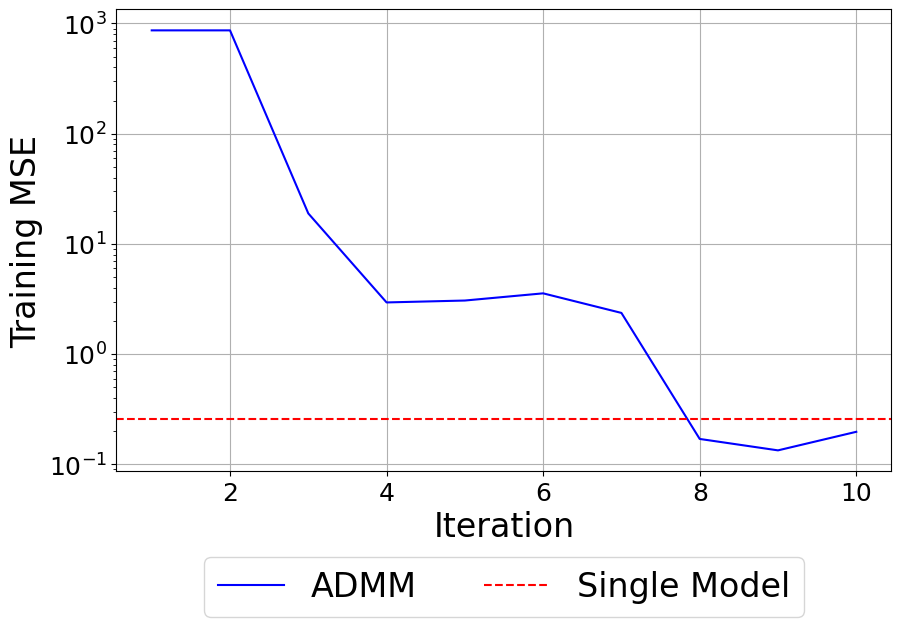

In [201]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot([i for i in range(1,len(admm_mse_diffrax)+1)], admm_mse_diffrax, label='ADMM', color='blue')

plt.axhline(y=mse_single, color='r', linestyle='--', label='Single Model')
plt.tick_params(axis='both', which='major', labelsize=18)
plt.xlabel('Iteration', fontsize=24)
plt.ylabel('Training MSE', fontsize=24)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=False, ncol=2, fontsize=24)
plt.grid(True)
plt.yscale('log')
plt.show()

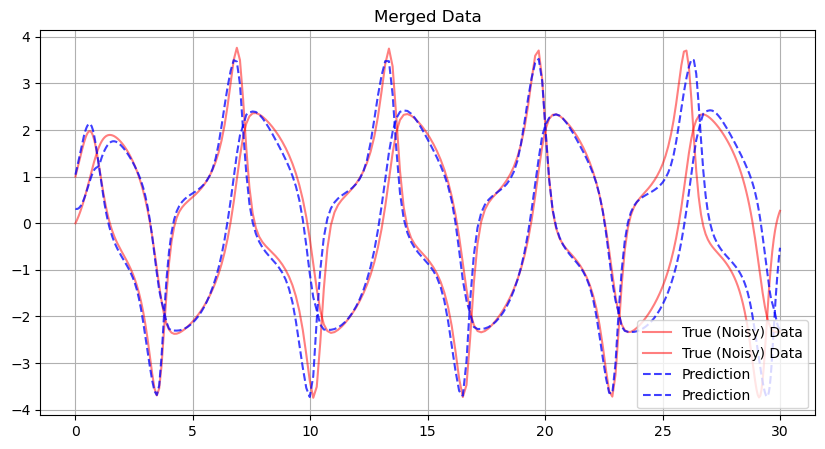

In [187]:
plt.figure(figsize=(10, 5))
plt.plot(ts_single, ys_single_true[:,0], label='True (Noisy) Data', color = 'red', alpha = 0.5)
plt.plot(ts_single, ys_single_true[:,1], label='True (Noisy) Data', color = 'red', alpha = 0.5)
plt.plot(ts_single[:], predictions, label='Prediction', color = 'blue', ls = '--', alpha = 0.75)
plt.legend(loc ="lower right")
plt.grid(True)
plt.title("Merged Data")
plt.show()

### Comparison ADMM vs Single model for 300 points

In [145]:
mse_diffrax_list = []

for run in results:
    mse_diffrax = run['mse_diffrax']
    mse_diffrax_list.append(mse_diffrax)

# Convert the list to a NumPy array
mse_diffrax_array = np.array(mse_diffrax_list)

import scipy.stats as stats

# Calculate mean across runs for each iteration
mean_mse = np.mean(mse_diffrax_array, axis=0)

# Calculate standard deviation across runs for each iteration
std_mse = np.std(mse_diffrax_array, axis=0, ddof=1)

# Number of runs
n_runs = mse_diffrax_array.shape[0]

# Standard error of the mean
sem_mse = std_mse / np.sqrt(n_runs)

# Confidence interval (95%)
confidence_level = 0.80
degrees_freedom = n_runs - 1
confidence_interval = stats.t.ppf((1 + confidence_level) / 2., degrees_freedom) * sem_mse

iterations = [i+1 for i in results[0]['iter']]  # Assuming all runs have the same 'iter' list

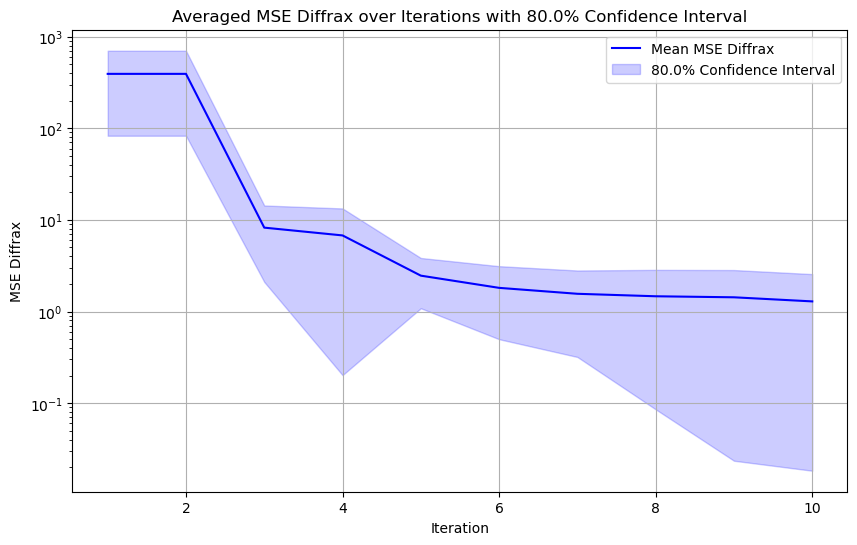

In [186]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plot mean mse_diffrax
plt.plot(iterations, mean_mse, label='Mean MSE Diffrax', color='blue')

# Plot confidence interval
plt.fill_between(iterations, mean_mse - confidence_interval, mean_mse + confidence_interval,
                 color='blue', alpha=0.2, label=f'{confidence_level*100}% Confidence Interval')

# Add labels and title
plt.xlabel('Iteration')
plt.ylabel('MSE Diffrax')
plt.title(f'Averaged MSE Diffrax over Iterations with {confidence_level*100}% Confidence Interval')
plt.legend()
plt.grid(True)
plt.yscale('log')
plt.show()